In [14]:
import re
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_style("ticks")


In [2]:
df = pd.read_csv('../data/metadata_with_tag.csv',
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str})

In [3]:
df_covid = df[df.tag_disease_covid19]

# Preprocessing

In [317]:
df['authors_list'] = df.authors.str.split(";")

In [318]:
author_papers = df.explode('authors_list')[['authors_list','sha']]
author_papers.columns = ['author_name','sha']
author_papers = author_papers.dropna()

In [319]:
author_papers.head(10)

,author_name,sha
0,"Madani, Tariq A",d1aafb70c066a2068b02786f8929fd9c900897fb
0,"Al-Ghamdi, Aisha A",d1aafb70c066a2068b02786f8929fd9c900897fb
1,"Vliet, Albert van der",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Eiserich, Jason P",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
1,"Cross, Carroll E",6b0567729c2143a66d737eb0a2f63f2dce2e5a7d
2,"Crouch, Erika C",06ced00a5fc04215949aa72528f2eeaae1d58927
3,"Fagan, Karen A",348055649b6b8cf2b9a376498df9bf41f7123605
3,"McMurtry, Ivan F",348055649b6b8cf2b9a376498df9bf41f7123605
3,"Rodman, David M",348055649b6b8cf2b9a376498df9bf41f7123605
4,"Domachowske, Joseph B",5f48792a5fa08bed9f56016f4981ae2ca6031b32


## Generalize Names

In [320]:
author_papers['author_name'] = author_papers['author_name'].str.replace(" ", "").str.replace(".","").str.replace(',',', ')

In [321]:
from mlxtend.text import generalize_names

In [77]:
unqiue_count =[]
for letters in range(1,20,2):
    unqiue_count.append(
        len(
            author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=letters))
            .unique()))

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


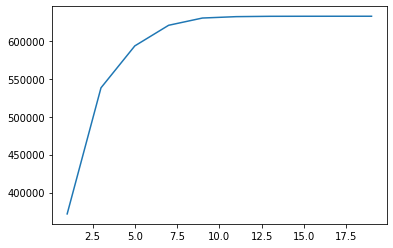

In [78]:
sns.lineplot(list( range(1,20,2)), unqiue_count)

In [322]:
author_papers['author_name'] = author_papers['author_name'].apply(
                lambda x: generalize_names(x, firstname_output_letters=5))

In [323]:
author_papers['author_name'].str.len().describe(percentiles=[.85,.9,.95,0.99,0.995,0.999,0.9995])

count     1.218020e+06
mean      1.094845e+01
std       3.585698e+00
min       0.000000e+00
50%       1.100000e+01
85%       1.400000e+01
90%       1.500000e+01
95%       1.700000e+01
99%       2.100000e+01
99.5%     2.200000e+01
99.9%     2.500000e+01
99.95%    2.600000e+01
max       9.800000e+01
Name: author_name, dtype: float64

In [324]:
author_papers = author_papers[(author_papers['author_name'].str.len() <= 25) 
                              & (author_papers['author_name'].str.len() > 0) 
                              & (author_papers['sha'] != False)
                              & (author_papers['author_name'] != 'false')]

author_papers['author_name'] = author_papers['author_name'].apply(lambda x:x.title())
author_papers.to_csv('../data/author_papers.csv',index=False)

In [325]:
len(covid_author_paper.author_name.unique())

365136

In [326]:
covid_paper = list(df_covid.sha.unique())
covid_author_paper = author_papers[author_papers.sha.isin(covid_paper)][['author_name','sha']]

# EDA

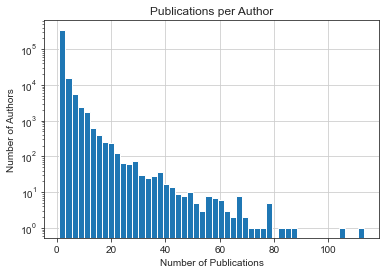

In [327]:
plt.title('Publications per Author')
plt.xlabel('Number of Publications')
plt.ylabel('Number of Authors')
covid_author_paper.groupby('author_name')['sha'].count().hist(bins=50,log=True)
plt.savefig('./pic/author_papers_hist.pdf')

In [328]:
covid_author_paper.groupby('author_name')['sha'].count().describe(percentiles=[0.75,0.9,0.95,0.99])

count    365136.000000
mean          1.701673
std           2.107762
min           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           4.000000
99%          10.000000
max         113.000000
Name: sha, dtype: float64

In [329]:
len(covid_author_paper.author_name.unique())

365136

In [330]:
author_paper_cnt = covid_author_paper.groupby('author_name')['sha'].count()
author_paper_cnt.name = 'paper_count'
filtered_author_index = author_paper_cnt[author_paper_cnt >= 10].index.to_list()
len(filtered_author_index)

3822

In [331]:
filtered_author_papers = covid_author_paper[covid_author_paper['author_name'].isin(filtered_author_index)]

In [332]:
len(filtered_author_papers)

61223

# Build Network

In [333]:
paper_dict = dict(enumerate(list(filtered_author_papers['sha'].unique())))
paper_dict = {v:k for k,v in paper_dict.items()}

In [334]:
author_dict = dict(enumerate(list(filtered_author_papers['author_name'].unique())))
author_dict = {v:k for k,v in author_dict.items()}

In [335]:
author_paper_tuple = list(zip(filtered_author_papers['author_name'], filtered_author_papers['sha']))

In [336]:
author_paper_tuple = [(author_dict[author], paper_dict[paper])for author, paper in author_paper_tuple]

In [337]:
from scipy.sparse import csc_matrix,lil_matrix

In [338]:
#AP[i,j] = 1 indicates that author i published paper j
AP = csc_matrix((np.ones(len(author_paper_tuple)), zip(*author_paper_tuple)))
##AA[i,j] = 1 indicates that author i published a paper with author j
AA = AP.dot(AP.T)

In [339]:
AA

<3822x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 106332 stored elements in Compressed Sparse Column format>

In [340]:
AA = AA.tolil()
AA.setdiag(0)

In [341]:
AA

<3822x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 102510 stored elements in List of Lists format>

In [342]:
#construct graph
G = nx.convert_matrix.from_scipy_sparse_matrix(AA)

# Network Analysis

In [343]:
degree = nx.degree(G)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=3000)

In [344]:
df_author = pd.DataFrame(author_dict.items())
df_author.columns= ['name','id']

In [345]:
df_author['degree'] = df_author['id'].apply(lambda x:degree[x])
df_author['degree_centrality'] = df_author['id'].apply(lambda x:degree_centrality[x])
df_author['eigenvector_centrality'] = df_author['id'].apply(lambda x:eigenvector_centrality[x])

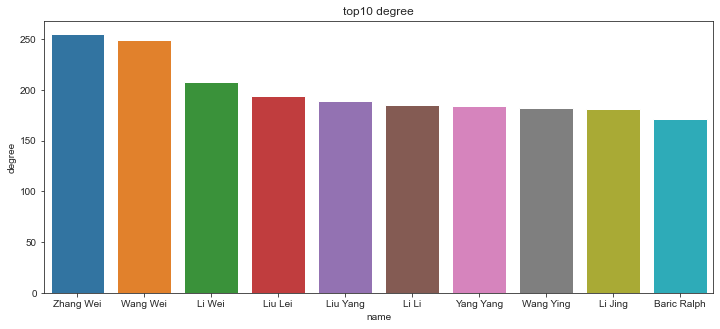

In [346]:
plt.figure(figsize=(12, 5))
plt.title('top10 degree')
sns.barplot(data=df_author.sort_values('degree',ascending=False)[:10], 
            x='name', y='degree')
plt.savefig('pic/top_10_degree.pdf')

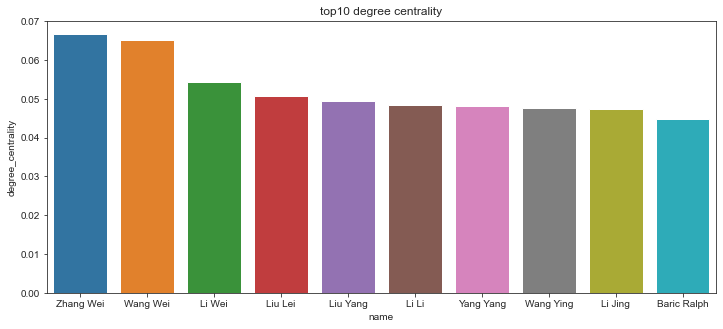

In [347]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('degree_centrality',ascending=False)[:10], 
            x='name', y='degree_centrality')
plt.savefig('pic/top_10_degree_centrality.pdf')

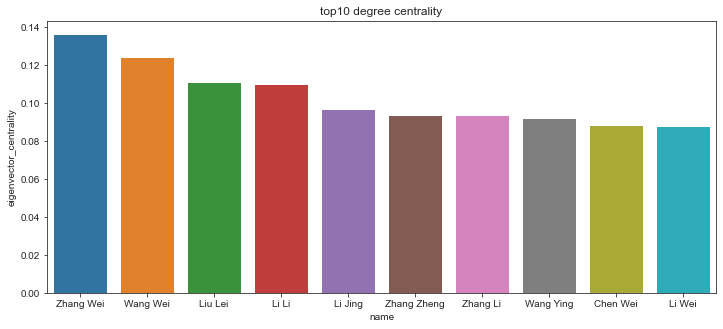

In [348]:
plt.figure(figsize=(12, 5))

plt.title('top10 degree centrality')
sns.barplot(data=df_author.sort_values('eigenvector_centrality',ascending=False)[:10], 
            x='name', y='eigenvector_centrality')
plt.savefig('pic/top_10_eigen_centrality.pdf')

# Community Detection

In [349]:
import community as community_louvain

In [350]:
partition = community_louvain.best_partition(G)

In [351]:
df_author['partition'] = df_author['id'].apply(lambda x:partition[x])

In [352]:
df_author = pd.merge(left=df_author, right= author_paper_cnt,how='left',left_on='name',right_on='author_name')
df_author_sampled = df_author[df_author.paper_count >= 10]
sampled_id = df_author_sampled.id.to_list()

In [357]:
len(df_author.partition.unique())

159

In [353]:
top5_community = list(df_author.groupby(partition).id.count().sort_values(ascending=False)[:5].index)

In [400]:
print(
    df_author[
    df_author.partition.isin(top5_community)].groupby(partition).apply(
    lambda x: x.nlargest(3, 'paper_count')).reset_index()[['name','partition']].groupby('partition')['name'].apply(list).to_latex()
)

\begin{tabular}{ll}
\toprule
{} &                                           name \\
partition &                                                \\
\midrule
0         &                 [Wang Wei, Zhang Wei, Liu Lei] \\
3         &                        [Zhang Y, Wang Y, Li Y] \\
4         &    [Zumla Alimu, Memish Ziada, Ippolito Giuse] \\
61        &    [Baric Ralph, Krammer Flori, Diamond Micha] \\
111       &  [Drosten Chris, Ciesek Sandr, Koopmans Mario] \\
\bottomrule
\end{tabular}



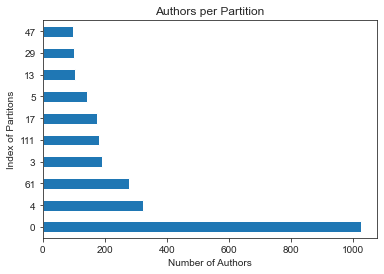

In [401]:
plt.title('Authors per Partition' )
plt.xlabel('Number of Authors')
plt.ylabel('Index of Partitons')
df_author.groupby(partition).id.count().sort_values(ascending=False)[:10].plot(kind='barh')
plt.savefig('./pic/author_per_partition.pdf')

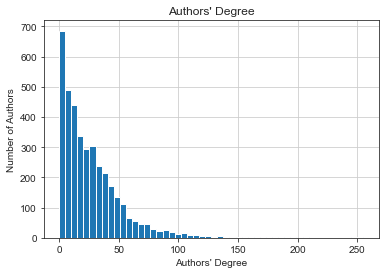

In [170]:
plt.title('Authors\' Degree' )
plt.xlabel('Authors\' Degree')
plt.ylabel('Number of Authors')
df_author['degree'].hist(bins=50)
plt.savefig('./pic/author_degree.svg')

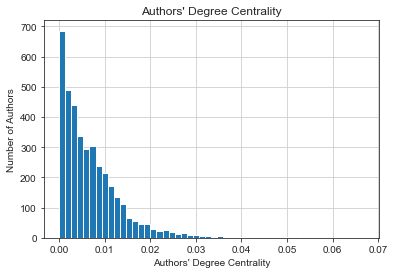

In [171]:
plt.title('Authors\' Degree Centrality' )
plt.xlabel('Authors\' Degree Centrality')
plt.ylabel('Number of Authors')
df_author['degree_centrality'].hist(bins=50)
plt.savefig('./pic/author_degree_centrality.svg')

In [275]:
modularity_dict = {}
adj_mat = nx.adjacency_matrix(G)
from sklearn.cluster import SpectralClustering
for n_clusters in np.linspace(50,500,10):
    n_clusters = int(n_clusters)
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)
    partitions_temp = sc.labels_
    partitions_temp = {i:label for i, label in enumerate(partitions_temp)}
    modularity_temp = community_louvain.modularity(partitions_temp, G)
    modularity_dict[n_clusters] = modularity_temp

/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/billy/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, 

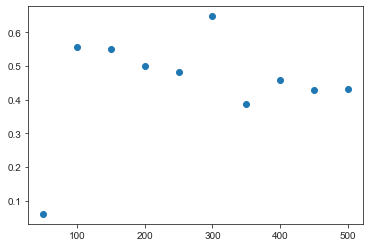

In [277]:
plt.scatter(modularity_dict.keys(), modularity_dict.values())

In [278]:
modularity_dict

{50: 0.06048425985655537,
 100: 0.5555917329196325,
 150: 0.5514632146550708,
 200: 0.49845788408735126,
 250: 0.48063667110888475,
 300: 0.6477007255319288,
 350: 0.388271479580823,
 400: 0.45691771037435897,
 450: 0.42808372854628596,
 500: 0.43058688102598736}

# TODO
1. Visualization
2. Other metrics 
3. Other algorithms 
4. With paper topic model